# Model s primjenom transferiranog učenja

## Početno postavljanje

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from matplotlib import pyplot as plt

# Funkcija za prikaz povijesti treniranja
def plot_all_metrics(history):
    epochs = range(1, len(history['accuracy']) + 1)

    metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc', 'loss']
    metric_titles = {
        'accuracy': 'Točnost',
        'precision': 'Preciznost',
        'recall': 'Osjetljivost',
        'auc': 'AUC',
        'loss': 'Gubitak'
    }

    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 6))

        # Graf trening metrika
        plt.plot(epochs, history[metric], 'bo', label=f'Trening {metric_titles[metric]}')

        # Graf validacijskih metrika
        val_metric = f'val_{metric}'
        plt.plot(epochs, history[val_metric], 'b', label=f'Validacija {metric_titles[metric]}')

        plt.title(f'Trening i validacija - {metric_titles[metric]}')
        plt.xlabel('Epoha')
        plt.ylabel(metric_titles[metric])
        plt.legend()

        plt.show()

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/cats_vs_dogs_baseline_subset/train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/cats_vs_dogs_baseline_subset/validation',
    label_mode='binary',
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    '/content/drive/MyDrive/cats_vs_dogs_baseline_subset/test',
    label_mode='binary',
    image_size=(180, 180),
    batch_size=32,
    shuffle=False
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## Ekstrakcija obilježja prethodno treniranog modela

### Konvolucijska baza

In [4]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Ekstrakcija obilježja i pripadnih oznaka

In [6]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 21ms/step


In [7]:
train_features.shape

(2000, 5, 5, 512)

### Arhitektura gustog klasifikatora i kompajliranje

In [8]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

### Treniranje gustog klasifikatora

In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/pre_trained_model_only.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=30,
    validation_data= (val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - 4s 25ms/step - loss: 9.0815 - accuracy: 0.9405 - precision: 0.9565 - recall: 0.9586 - auc: 0.9298 - val_loss: 5.4555 - val_accuracy: 0.9640 - val_precision: 0.9637 - val_recall: 0.9857 - val_auc: 0.9517
Epoch 2/30
63/63 [==============================] - 0s 8ms/step - loss: 4.0203 - accuracy: 0.9785 - precision: 0.9850 - recall: 0.9843 - auc: 0.9753 - val_loss: 4.8674 - val_accuracy: 0.9720 - val_precision: 0.9773 - val_recall: 0.9829 - val_auc: 0.9671
Epoch 3/30
63/63 [==============================] - 0s 6ms/step - loss: 1.1452 - accuracy: 0.9905 - precision: 0.9922 - recall: 0.9943 - auc: 0.9880 - val_loss: 4.9604 - val_accuracy: 0.9770 - val_precision: 0.9774 - val_recall: 0.9900 - val_auc: 0.9700
Epoch 4/30
63/63 [==============================] - 0s 6ms/step - loss: 0.9120 - accuracy: 0.9950 - precision: 0.9964 - recall: 0.9964 - auc: 0.9940 - val_loss: 5.2828 - val_accuracy: 0.9750 - val_precision: 0.9884 - val_recall: 0.9757 -

### Rezultati

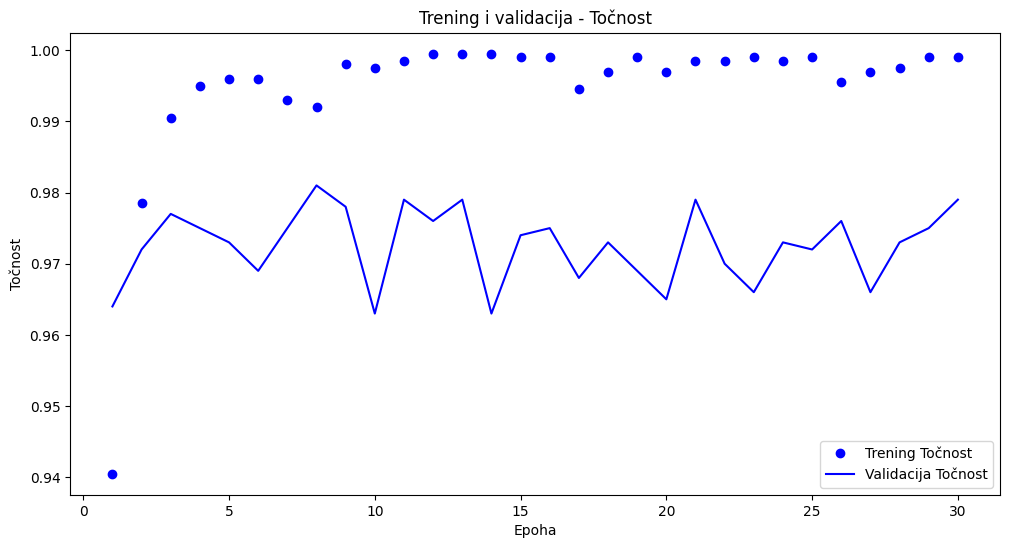

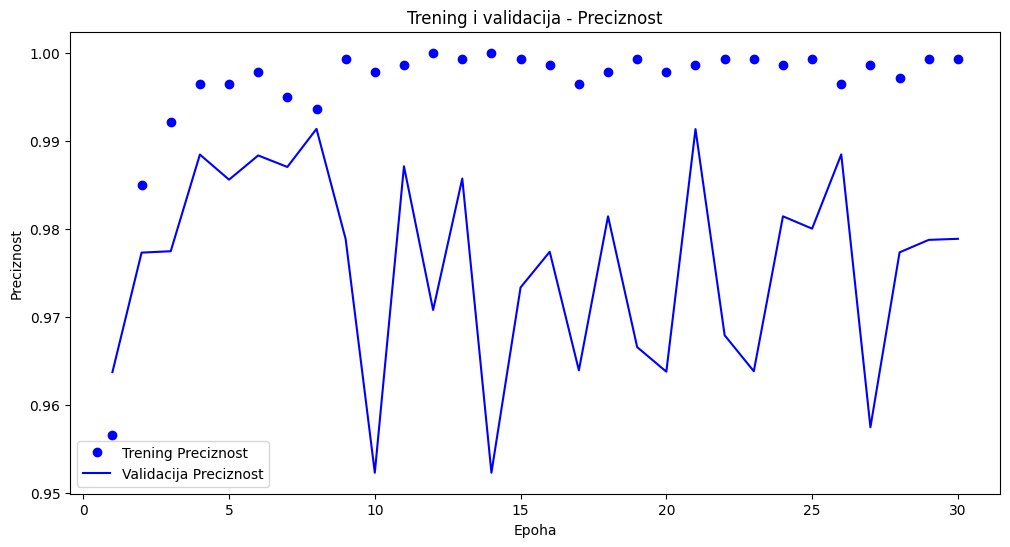

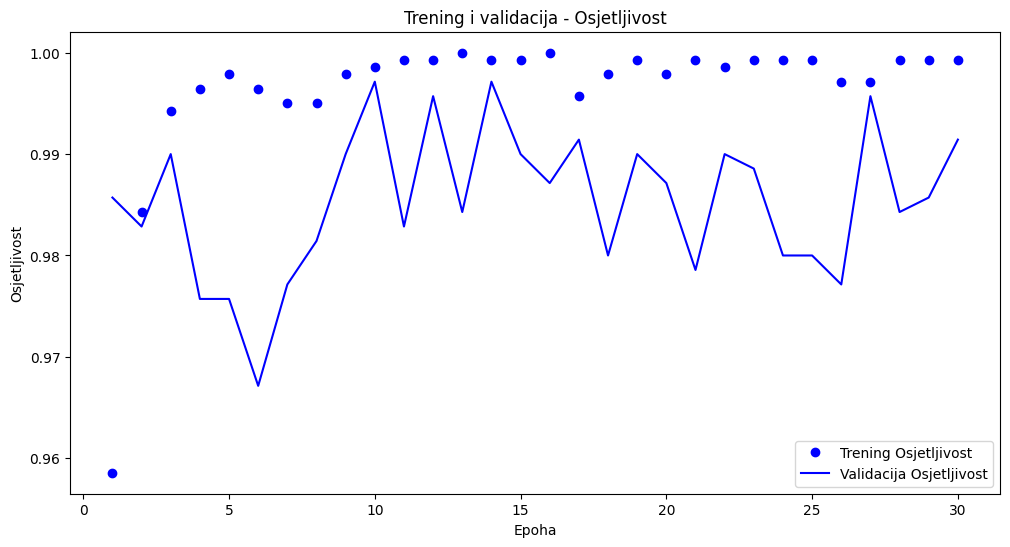

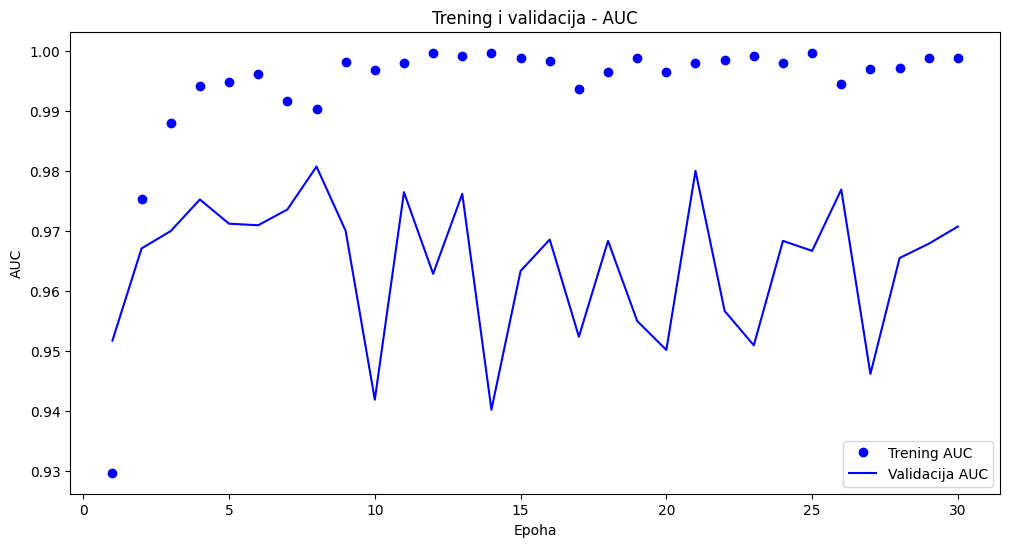

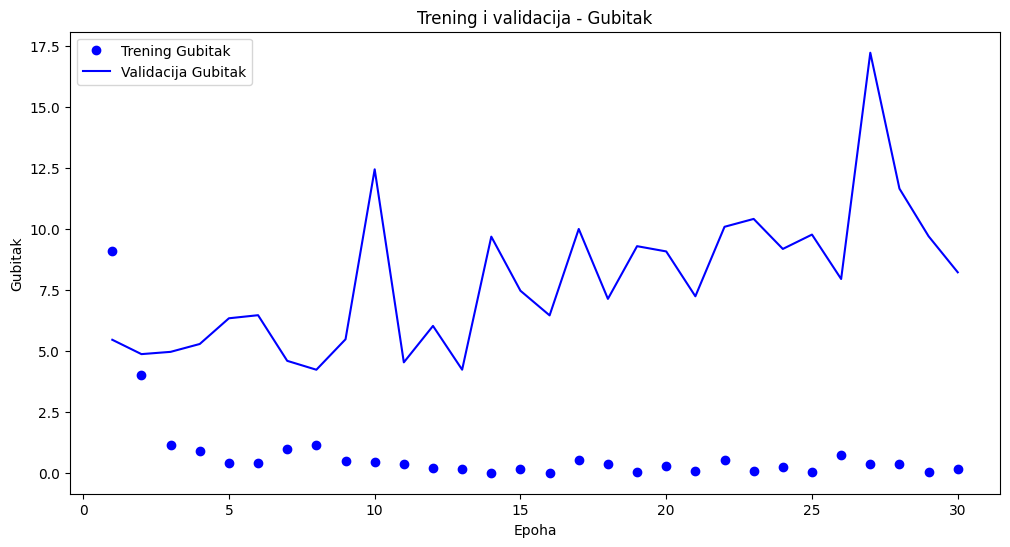

In [10]:
plot_all_metrics(history.history)

In [11]:
from tensorflow.keras import metrics

# Učitavanje najboljeg modela (po gubitku)
test_model = keras.models.load_model("/content/drive/MyDrive/pre_trained_model_only.keras")

# Evaluacija najboljeg modela nad testnim podatkovnim setom
test_metrics = test_model.evaluate(test_features,test_labels)

# test_metrics u prvom elementu ima spremljen gubitak,
# ostali elementi su metrike redom pojavljivanja kao i kod kompajliranja modela
print(f"Test gubitak: {test_metrics[0]:.3f}")
print(f"Test točnost: {test_metrics[1]:.3f}")
print(f"Test preciznost: {test_metrics[2]:.3f}")
print(f"Test osjetljivost: {test_metrics[3]:.3f}")
print(f"Test AUC: {test_metrics[4]:.3f}")


63/63 [==============================] - 0s 3ms/step - loss: 5.7309 - accuracy: 0.9800 - precision: 0.9906 - recall: 0.9807 - auc: 0.9802
Test gubitak: 5.731
Test točnost: 0.980
Test preciznost: 0.991
Test osjetljivost: 0.981
Test AUC: 0.980


### Performanse modela nad manje zastupljenom klasom

In [12]:
import numpy as np

# Ekstrakcija istinitih vrijednosti i predviđenih vjerojatnosti iz testnog seta
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = test_model.predict(test_features)

63/63 [==============================] - 0s 2ms/step


In [13]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Konverzija predviđenih vjerojatnosti u dvije klase
y_pred_labels = (y_pred > 0.5).astype("int32")

# Detaljizirano klasifikacijsko izvješće
print(classification_report(y_true, y_pred_labels, target_names=['mačka', 'pas']))

# Metrike za klasu mačka.
precision = precision_score(y_true, y_pred_labels, pos_label=0)
recall = recall_score(y_true, y_pred_labels, pos_label=0)
f1 = f1_score(y_true, y_pred_labels, pos_label=0)

print(f'Preciznost za klasu mačka: {precision:.3f}')
print(f'Osjetljivost za klasu mačka: {recall:.3f}')
print(f'F1 metrika za klasu mačka: {f1:.3f}')


              precision    recall  f1-score   support

       mačka       0.96      0.98      0.97       600
         pas       0.99      0.98      0.99      1400

    accuracy                           0.98      2000
   macro avg       0.97      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

Preciznost za klasu mačka: 0.956
Osjetljivost za klasu mačka: 0.978
F1 metrika za klasu mačka: 0.967


## Fino podešavanje prethodno treniranog modela

Odmrzavanje posljednja četiri sloja u 5. bloku slojeva VGG16 modela.

In [14]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### Kompajliranje modela

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

### Treniranje modela

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/pre_trained_model_fine_tuned.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=60,
    validation_data= (val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/60
63/63 [==============================] - 1s 20ms/step - loss: 0.1010 - accuracy: 0.9990 - precision: 0.9986 - recall: 1.0000 - auc: 0.9983 - val_loss: 7.2951 - val_accuracy: 0.9780 - val_precision: 0.9843 - val_recall: 0.9843 - val_auc: 0.9754
Epoch 2/60
63/63 [==============================] - 0s 6ms/step - loss: 0.0514 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.9993 - auc: 0.9996 - val_loss: 7.3014 - val_accuracy: 0.9780 - val_precision: 0.9843 - val_recall: 0.9843 - val_auc: 0.9754
Epoch 3/60
63/63 [==============================] - 0s 6ms/step - loss: 4.5885e-31 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 7.3028 - val_accuracy: 0.9780 - val_precision: 0.9843 - val_recall: 0.9843 - val_auc: 0.9738
Epoch 4/60
63/63 [==============================] - 0s 6ms/step - loss: 0.0720 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.9993 - auc: 0.9996 - val_loss: 7.3114 - val_accuracy: 0.9780 - val_precision: 0.9843 - val_recall: 0.98

### Rezultati

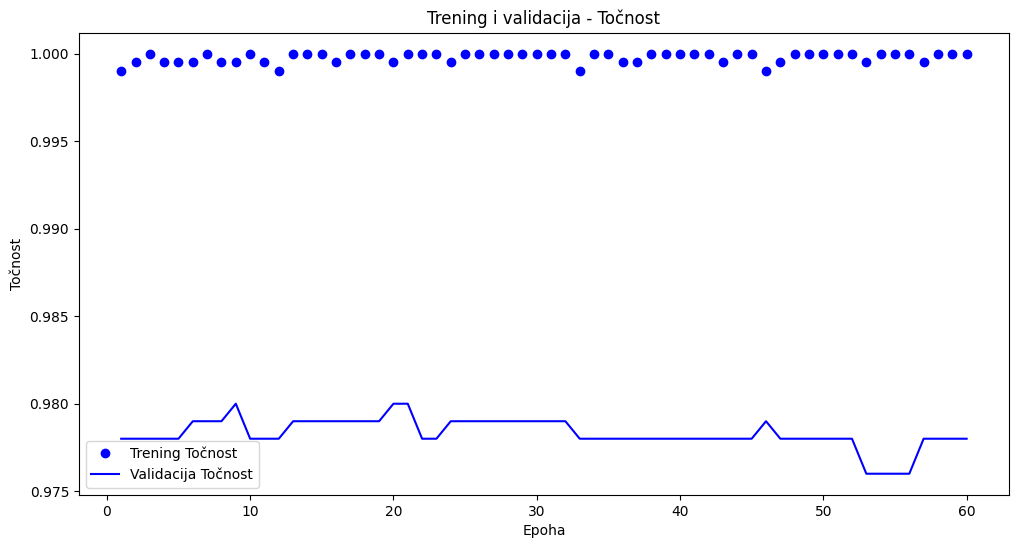

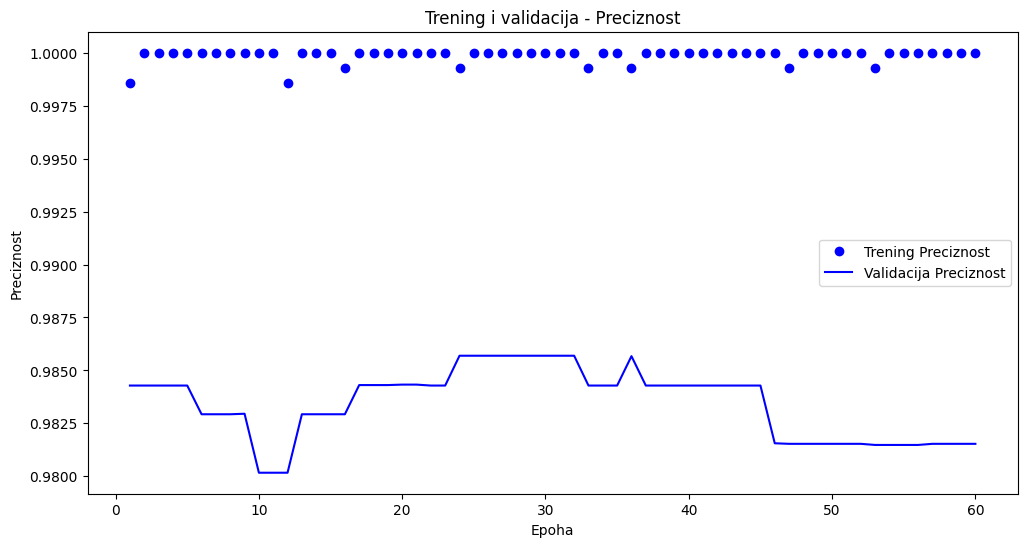

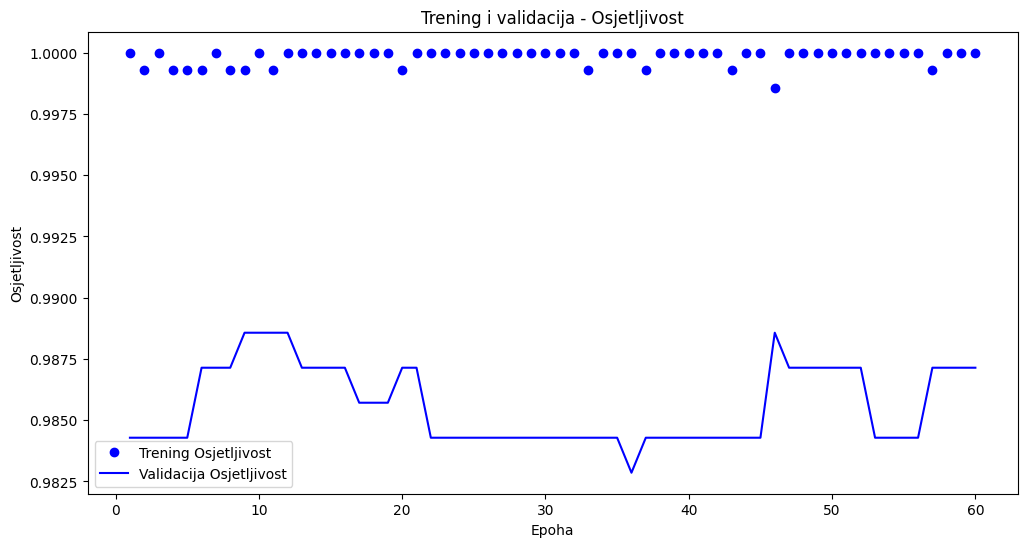

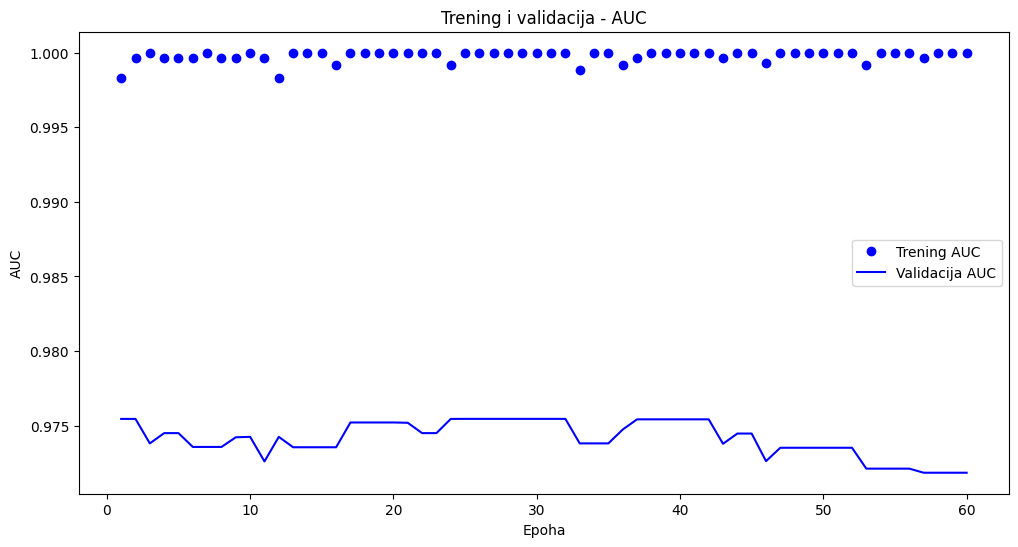

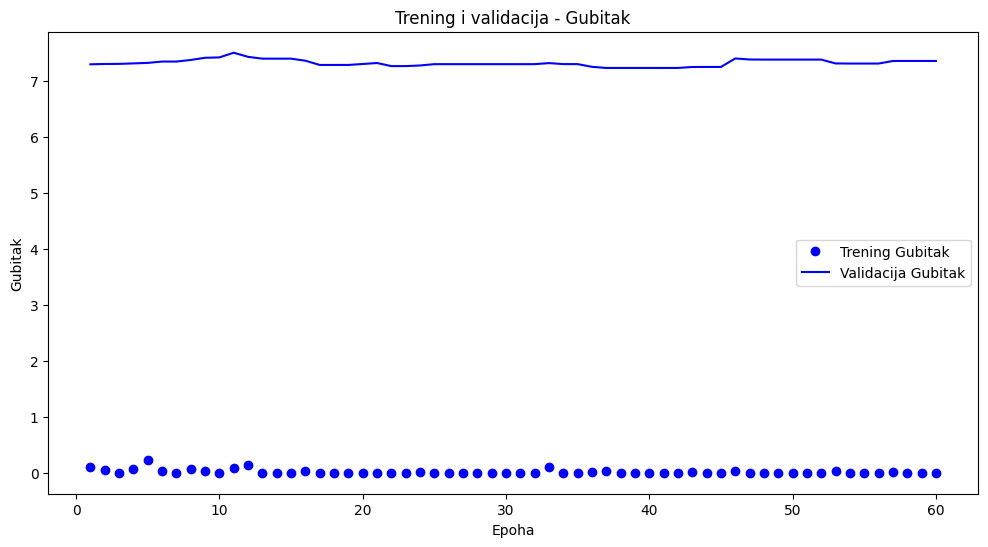

In [18]:
plot_all_metrics(history.history)

In [19]:
from tensorflow.keras import metrics

# Učitavanje najboljeg modela (po gubitku)
test_model = keras.models.load_model("/content/drive/MyDrive/pre_trained_model_fine_tuned.keras")

# Evaluacija najboljeg modela nad testnim podatkovnim setom
test_metrics = test_model.evaluate(test_features,test_labels)

# test_metrics u prvom elementu ima spremljen gubitak,
# ostali elementi su metrike redom pojavljivanja kao i kod kompajliranja modela
print(f"Test gubitak: {test_metrics[0]:.3f}")
print(f"Test točnost: {test_metrics[1]:.3f}")
print(f"Test preciznost: {test_metrics[2]:.3f}")
print(f"Test osjetljivost: {test_metrics[3]:.3f}")
print(f"Test AUC: {test_metrics[4]:.3f}")


63/63 [==============================] - 0s 3ms/step - loss: 9.1874 - accuracy: 0.9820 - precision: 0.9892 - recall: 0.9850 - auc: 0.9800
Test gubitak: 9.187
Test točnost: 0.982
Test preciznost: 0.989
Test osjetljivost: 0.985
Test AUC: 0.980


In [22]:
import numpy as np

# Ekstrakcija istinitih vrijednosti i predviđenih vjerojatnosti iz testnog seta
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = test_model.predict(test_features)

63/63 [==============================] - 0s 2ms/step


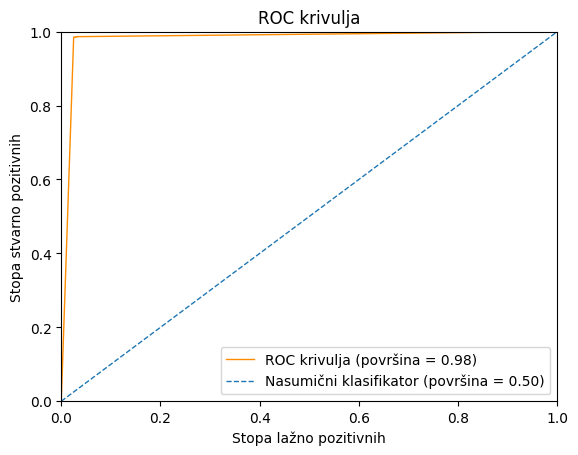

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC krivulja i AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Vrijednosti nasumičnog klasifikatora (50%)
fpr_random = [0, 1]
tpr_random = [0, 1]

# Crtanje ROC krivulje
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC krivulja (površina = %0.2f)' % roc_auc)
plt.plot(fpr_random, tpr_random, linestyle='--', lw=1, label='Nasumični klasifikator (površina = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Stopa lažno pozitivnih')
plt.ylabel('Stopa stvarno pozitivnih')
plt.title('ROC krivulja')
plt.legend(loc="lower right")
plt.show()

### Performanse modela nad manje zastupljenom klasom

In [24]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Konverzija predviđenih vjerojatnosti u dvije klase
y_pred_labels = (y_pred > 0.5).astype("int32")

# Detaljizirano klasifikacijsko izvješće
print(classification_report(y_true, y_pred_labels, target_names=['mačka', 'pas']))

# Metrike za klasu mačka.
precision = precision_score(y_true, y_pred_labels, pos_label=0)
recall = recall_score(y_true, y_pred_labels, pos_label=0)
f1 = f1_score(y_true, y_pred_labels, pos_label=0)

print(f'Preciznost za klasu mačka: {precision:.3f}')
print(f'Osjetljivost za klasu mačka: {recall:.3f}')
print(f'F1 metrika za klasu mačka: {f1:.3f}')


              precision    recall  f1-score   support

       mačka       0.97      0.97      0.97       600
         pas       0.99      0.98      0.99      1400

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

Preciznost za klasu mačka: 0.965
Osjetljivost za klasu mačka: 0.975
F1 metrika za klasu mačka: 0.970
